In [334]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [335]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Documents/4.Work/Interviews/CreditorWatch/xyz-billing.csv', parse_dates=['date'], dayfirst=True, infer_datetime_format=True)

In [336]:
df.head()

,customerID,date,itemDescription,amount
0,customer1,2021-01-31,annual subscription,1200
1,customer1,2022-01-31,annual subscription,1200
2,customer2,2021-03-31,annual subscription,600
3,customer3,2021-03-31,annual subscription,900
4,customer3,2021-11-30,calendar purchase,50


In [337]:
# 62 Transactions with 4 fields
df.shape

(62, 4)

In [338]:
# Transactions by payment type/plan
df['itemDescription'].value_counts()

monthly subscription    41
calendar purchase       17
annual subscription      4
Name: itemDescription, dtype: int64

In [339]:
# Range of transactions
print('first purchase', df['date'].min())
print('last purchase', df['date'].max())

first purchase 2021-01-31 00:00:00
last purchase 2022-06-30 00:00:00


#### Tasks

**Task 1:** Produce either a visualization or table to show the total monthly MRR for January 2021 to June 2022 as at each month end.

##### Task 1: Code

In [340]:
# Create a new column for MRR
df['MRR'] = 0

In [341]:
# Identify annual subscriptions
annual_subs = df[df['itemDescription'] == 'annual subscription']

# Initialize an empty list to store new rows
new_rows = []

# Iterate through annual subscriptions
for index, row in annual_subs.iterrows():
    billing_month = row['date']
    mrr_amount = row['amount'] / 12

    # Create new rows for each month in the next 12 months for the specific customer
    for i in range(12):
        next_month = billing_month + pd.DateOffset(months=i + 1)
        new_row = {
            'date': next_month,
            'itemDescription': 'annual subscription',
            'amount': mrr_amount,
            'MRR': mrr_amount,
            'customerID': row['customerID'],
            'Type': 'MRR'
        }
        new_rows.append(new_row)

# Concatenate the new rows to the original DataFrame
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

In [342]:
# Calculate MRR for monthly subscriptions
monthly_subs = df[df['itemDescription'] == 'monthly subscription']
df.loc[monthly_subs.index, 'MRR'] = monthly_subs['amount']
df.loc[monthly_subs.index, 'Type'] = 'MRR'

In [343]:
# Calculate MRR for calendar purchases
calendar_purchases = df[df['itemDescription'] == 'calendar purchase']
df.loc[calendar_purchases.index, 'MRR'] = calendar_purchases['amount']
df.loc[calendar_purchases.index, 'Type'] = 'One-off'

In [344]:
# Category/Label
df['Category'] = df['itemDescription'] + ' - ' + df['Type']

In [345]:
# Remove rows where MRR is 0
df = df[df['MRR'] != 0]

#### Task 1: Visualization

In [346]:
# Visualize total monthly MRR
monthly_mrr = df.groupby('date')['MRR'].sum().reset_index()

# Visualize total monthly MRR with Month Year format on X-axis
monthly_mrr['Month_Year'] = monthly_mrr['date'].dt.strftime('%b %Y')

# Set color based on the magnitude of MRR values
color_palette = sns.color_palette("coolwarm", n_colors=len(monthly_mrr))
colors = monthly_mrr['MRR'].abs() / monthly_mrr['MRR'].abs().max()
monthly_mrr['Color'] = [color_palette[int(x * (len(color_palette)-1))] for x in colors]

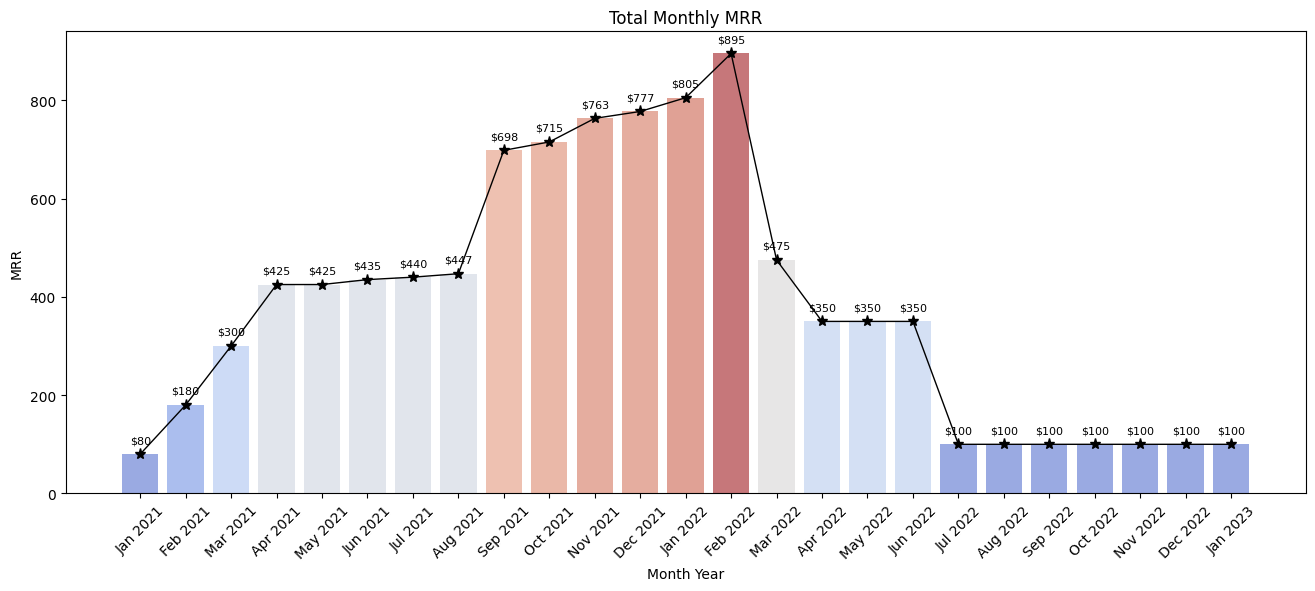

In [347]:
plt.figure(figsize=(16, 6))

# Bar chart for total monthly MRR
ax = sns.barplot(x='Month_Year', y='MRR', data=monthly_mrr, palette=monthly_mrr['Color'], alpha=0.7)
plt.title('Total Monthly MRR')
plt.xlabel('Month Year')
plt.ylabel('MRR')

# Line chart for total monthly MRR
monthly_mrr['MRR'].plot(color='black', marker='*', linestyle='-', linewidth=1, markersize=8, label='Line Chart')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate each bar with its MRR value
for p in ax.patches:
    ax.annotate(f'${int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8, color='black')

plt.show()

**Task 2:** Produce a visualization or table to show the monthly growth rates of MRR and calendar purchases (as separate categories). The monthly growth rate is the defined as the percentage change from the previous month.

#### Task 2: Code

In [348]:
df['Month_Year'] = df['date'].dt.strftime('%b %Y')

In [349]:
# Calculate monthly subscriptions growth rates
monthly_subs = df[df['Type']=='MRR']
monthly_subs_gr = monthly_subs.groupby(['Month_Year', 'Type'])['MRR'].sum().reset_index()
monthly_subs_gr['Month_Year'] = pd.to_datetime(monthly_subs_gr['Month_Year'], format='%b %Y')
monthly_subs_gr = monthly_subs_gr.sort_values(by='Month_Year')
monthly_subs_gr['MRR_Growth'] = round(monthly_subs_gr['MRR'].pct_change() * 100,2)

In [350]:
# Calculate calendar purchases growth rates
calendar_purchases = df[df['Type']=='One-off']
calendar_purchases_gr = calendar_purchases.groupby(['Month_Year', 'Type'])['MRR'].sum().reset_index()
calendar_purchases_gr['Month_Year'] = pd.to_datetime(calendar_purchases_gr['Month_Year'], format='%b %Y')
calendar_purchases_gr = calendar_purchases_gr.sort_values(by='Month_Year')
calendar_purchases_gr['MRR_Growth'] = round(calendar_purchases_gr['MRR'].pct_change() * 100,2)

In [351]:
growth_rates = pd.concat([monthly_subs_gr, calendar_purchases_gr], axis=0)
growth_rates['Month_Year'] = growth_rates['Month_Year'].dt.strftime('%b %Y')

#### Task 2: Visualisation

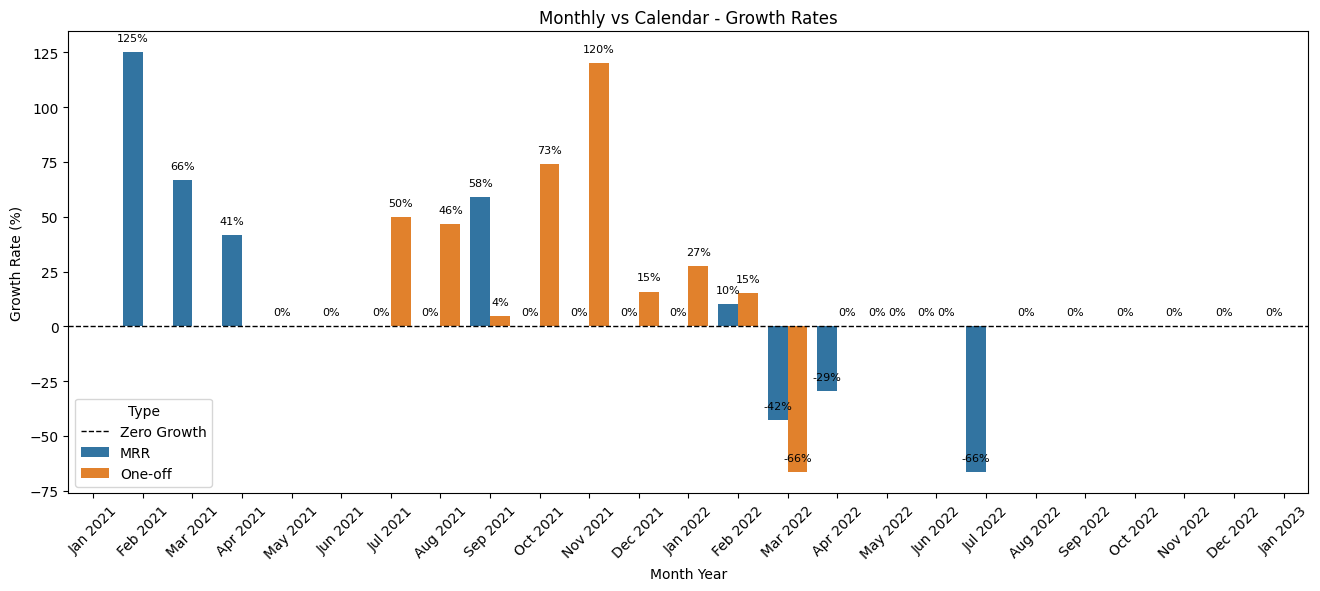

In [352]:
plt.figure(figsize=(16, 6))

# Bar chart for growth rates
ax = sns.barplot(x='Month_Year', y='MRR_Growth', hue='Type', data=growth_rates)

plt.title('Monthly vs Calendar - Growth Rates')
plt.xlabel('Month Year')
plt.ylabel('Growth Rate (%)')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotate each bar with its growth rate value
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(f'{int(height)}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8, color='black')

# Add a reference line for zero growth
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Zero Growth')

# Add legend
plt.legend(title='Type')

plt.show()

**Task 3:** As a SaaS it’s important to identify when customers are churning, produce a table or visualization to identify how many customers have churned each month between December 2021 and March 2022 (both months inclusive) where churn is defined as a customer having a non zero-MRR amount attributed in the previous month but no MRR in the current month.

> Eg MRRt-1 > 0 and MRRt = 0 where t is the month.





#### Task 3: Code

In [353]:
# Excluding one-off transactions
df = df[df['Type']!='One-off']

In [354]:
df.head()

,customerID,date,itemDescription,amount,MRR,Type,Category,Month_Year
12,customer4,2021-01-31,monthly subscription,80.0,80.0,MRR,monthly subscription - MRR,Jan 2021
13,customer4,2021-02-28,monthly subscription,80.0,80.0,MRR,monthly subscription - MRR,Feb 2021
14,customer4,2021-03-31,monthly subscription,80.0,80.0,MRR,monthly subscription - MRR,Mar 2021
15,customer4,2021-04-30,monthly subscription,80.0,80.0,MRR,monthly subscription - MRR,Apr 2021
16,customer4,2021-05-31,monthly subscription,80.0,80.0,MRR,monthly subscription - MRR,May 2021


In [355]:
churn_df = df.groupby(['customerID','Month_Year'])['MRR'].sum().reset_index()

churn_df['Month_Year'] = pd.to_datetime(churn_df['Month_Year'], format='%b %Y')

# Sort the DataFrame by customerID and Month_Year
churn_df = churn_df.sort_values(by=['customerID', 'Month_Year']).reset_index(drop=True)

In [356]:
# Identify churn

# Create a column for the temporary next month's date
churn_df['next_month_date'] = churn_df.groupby('customerID')['Month_Year'].shift(-1)

# Create the isChurned column based on the conditions
churn_df['isChurned'] = (churn_df['next_month_date'].isna()).astype(int)

In [357]:
churn_df = churn_df.loc[(churn_df['Month_Year'] >= '2021-12-01') & (churn_df['Month_Year'] <= '2022-03-31')].copy()

churn_df['Month_Year'] = pd.to_datetime(churn_df['Month_Year'], format='%b %Y')

churn_df_summary = churn_df.groupby(churn_df['Month_Year'].dt.strftime('%b %Y'))['isChurned'].sum().reset_index()

churn_df_summary = churn_df_summary.rename(columns={'isChurned': 'Customers Churned'})

#### Task 3: Table

In [358]:
# Excludes one-off transactions
churn_df_summary.head()

,Month_Year,Customers Churned
0,Dec 2021,0
1,Feb 2022,2
2,Jan 2022,0
3,Mar 2022,2
